In [49]:
from qwanta.Qubit import PhysicalQubit , DirectFidelityEstimator, GetQubit
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

In [13]:

def GetQubit(memoryFunction=None, gate_error=None, measurementError=None):
    
    node = 'DummyNode'
    qubitID = 'Qubit1'
    qnic = 'QNIC1'
    role = 'Physical'
    table = 'Table1'
    env = VirtualEnv()
    memoryFunction = memoryFunction if memoryFunction is not None else [1, 0, 0, 0]
    gate_error = gate_error if gate_error is not None else 0
    measurementError = measurementError if measurementError is not None else 0

    q = PhysicalQubit(node, qubitID, qnic, role, env, table, memoryFunction, gate_error, measurementError)
    q.setInitialTime()
    
    return q

class VirtualEnv:
    """
    Create initialize information for physical qubit
    """
    def __init__(self, time=0):
        self.now = time

class DirectFidelityEstimator:

    def __init__(self, stabilizers) -> None:


        # Check if stabilizers contain identity or not
        # if conained exclude it

        for stab in stabilizers:
            if stab.count('I') == len(stab):
                stabilizers.remove(stab)

        self.stabilizers = stabilizers
        self.n_stabilizers = len(stabilizers) + 1

        self.expectation_values = {
            stab : {
                'commute': 0,
                'anti-commute': 0
            }
        for stab in self.stabilizers}

        self.num_measured = 0

    def add_readout(self, readout, stabilizer):

        # Check if readout commute with stabilizer 
        is_that_commute = self.is_commute(readout, stabilizer)
        if is_that_commute:
            self.expectation_values[stabilizer]['commute'] += 1
        else:
            self.expectation_values[stabilizer]['anti-commute'] += 1

        self.num_measured += 1

    def measure(self, qubits):

        if not isinstance(qubits, list):
            qubits = [qubits]

        # Randomly choose stabilizer to measure
        stabilizer = np.random.choice(self.stabilizers)

        readout = []
        for stab, qubit in zip(stabilizer, qubits):
            readout.append(qubit.measure(basis=stab))
                
        # Check if readout commute with stabilizer 
        is_that_commute = self.is_commute(readout, stabilizer)
        if is_that_commute:
            self.expectation_values[stabilizer]['commute'] += 1
        else:
            self.expectation_values[stabilizer]['anti-commute'] += 1

        self.num_measured += 1

        return True

    def is_commute(self, readout, stabilizer):

        result = 0
        for ro, stab in zip(readout, stabilizer):
            if (stab != 'I') and ro:
                # Anti-commute
                result += 1

        return False if result % 2 == 1 else True

    def estimate_fidelity(self):

        # Check if fidelity could be estimate
        summation = 0
        for stab in self.expectation_values:

            if (self.expectation_values[stab]['commute'] + self.expectation_values[stab]['anti-commute']) < 1:
                return None

            exp_val = (self.expectation_values[stab]['commute'] - \
                       self.expectation_values[stab]['anti-commute']) \
                       /(self.expectation_values[stab]['commute'] + \
                       self.expectation_values[stab]['anti-commute'])
            
            summation += exp_val

        self.fidelity = (1 / self.n_stabilizers)*(1 + summation)

        return self.fidelity

In [8]:
def is_commute(readout, stabilizer):

        # readout = [True, False]
        # stabilizers = ['I', 'Z']

        result = 0
        for ro, stab in zip(readout, stabilizer):
            if (stab != 'I') and ro:
                # Anti-commute
                result += 1

        return True if result % 2 == 1 else False

### Single qubit gate error

A single-qubit gate error channel is model as,
$$
\begin{equation}
    \epsilon_{\text{gate}}(\rho) = (1 - p_{gate})O \rho O^{\dagger} + \frac{p_{gate} }{4}\sum_{i=\{I, X, Y, Z\}} G_{i} \rho G_{i}^{\dagger}.
\end{equation}
$$
Given stabilizer state of sigle qubit as a input as,

$$
\begin{equation}
    \rho = |\psi\rangle \langle \psi|,
\end{equation}
$$
A fidelity to the 
$$
\begin{equation}
    |0\rangle \langle 0| = \frac{1}{2} (I + Z),
\end{equation}
$$
 is therefore,

$$
\begin{equation}
    F = \frac{1}{2} (1 + (1 - p_{\text{gate}})\langle \psi| O^{\dagger} Z O |\psi\rangle + \frac{p_{gate} }{4}\sum_{i=\{I, X, Y, Z\}} \langle \psi | G_{i} Z G_{i}^{\dagger} |\psi \rangle )
\end{equation}
$$

If input state is $|0\rangle$, and $O = I$ then fidelity should be,
$$
\begin{equation}
    F = \frac{1}{2}(1 + \langle Z \rangle) = 1 - \frac{p_{\text{gate}}}{2} = \frac{1}{2}(1 + p_{\text{commute}} - p_{\text{anti}})
\end{equation}
$$

In [2]:
# Analytic function
def fidelity_gate_error(x):
    return 1 - 0.5*x

In [3]:
# Execute experiment as follow

# Define stabilizers set
stabilizers = ['Z']

# Specify number of execution for each gate error
num = 10000

# Define gate error
gate_error_range = np.linspace(0, 1, 11)

# Result list
DEF_Fidelities = []

for g_e in gate_error_range:
    # Initial estimator instance
    DEF = DirectFidelityEstimator(stabilizers)

    for index in range(num):
        # Initialize qubit
        test_qubit = GetQubit(gate_error=g_e)
        # Apply hadamard gate as it does nothing on qubit if there is no piror noise
        test_qubit.I_gate()

        # Measure the qubit
        DEF.measure(test_qubit) 
          
    DEF_Fidelities.append(DEF.estimate_fidelity())

In [77]:
# Convergence testing

# Define stabilizers set
stabilizers = ['Z']

# Specify number of execution for each gate error
num = 10000
num_trials = 100

# Define gate error
gate_error_range = [ 0.05, 0.1, 0.15, .2]

fidelities_gate_errors = []
for g_e in gate_error_range:

    analytic_fidelity = fidelity_gate_error(g_e)

    for trial in range(num_trials):

        DFE = DirectFidelityEstimator(stabilizers)
        for measure_shot in range(num):

            # Initialize qubit
            test_qubit = GetQubit(gate_error=g_e)
            # Apply hadamard gate as it does nothing on qubit if there is no piror noise
            test_qubit.I_gate()

            # Measure the qubit
            DFE.measure(test_qubit) 
            fidelities_gate_errors.append({
                'Gate error': g_e,
                'trial': trial, 
                'shot': measure_shot + 1,
                '|$F_r - F_s$|': abs(analytic_fidelity - DFE.estimate_fidelity())
            })

data = pd.DataFrame(fidelities_gate_errors)

(0.0, 0.04)

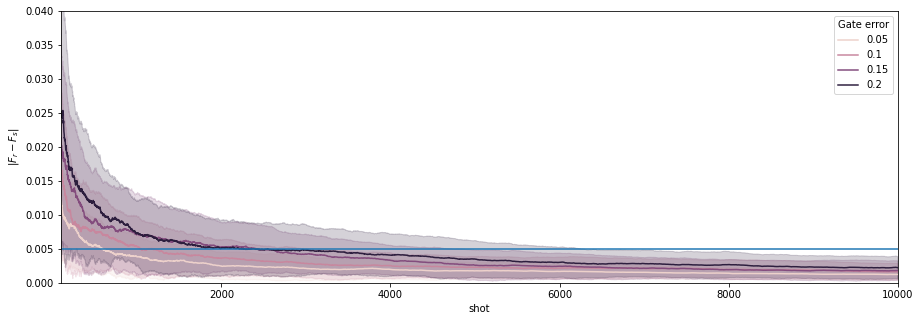

In [78]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data, x='shot', y='|$F_r - F_s$|', hue='Gate error', ci='sd')
plt.hlines(0.005, xmin=100, xmax=num)
plt.xlim(100, num)
plt.ylim(0, 0.04)

Text(0, 0.5, 'Fidelity')

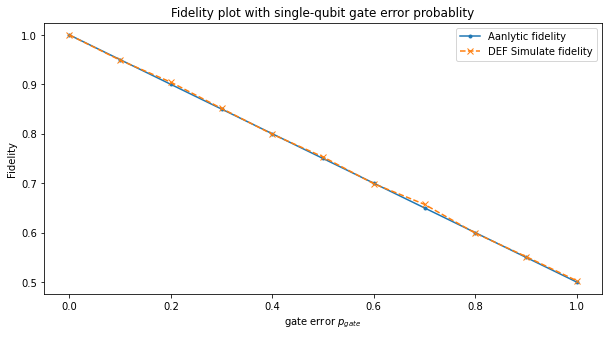

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(gate_error_range, fidelity_gate_error(gate_error_range), '.-', label='Aanlytic fidelity')
plt.plot(gate_error_range, DEF_Fidelities, 'x--', label='DEF Simulate fidelity')
plt.legend()
plt.title('Fidelity plot with single-qubit gate error probablity'); plt.xlabel('gate error $p_{gate}$'); plt.ylabel('Fidelity')
# plt.savefig('modelfidelityFigures/IgateFideility.png')

### Two-qubit gate error

A two-qubits gate error channel is model as,
$$
\begin{equation}
    \epsilon_{\text{gate}}(\rho) = (1 - p_{gate})O \rho O^{\dagger} + \frac{p_{gate} }{16}\sum_{i, j=\{I, X, Y, Z\}} G_{i}G_{j} \rho G_{i}^{\dagger}G_{j}^{\dagger}.
\end{equation}
$$

In [5]:
# Analytic function
def fidelity_TwoGate_error(x):
    return 0.25 + 0.75*(1 - x)

In [11]:
# Execute experiment as follow

# Define stabilizers set 
stabilizers = ['IZ', 'ZI', 'ZZ']# [[0, 3], [3, 0], [3, 3]] # |00>

# Specify number of execution for each gate error
num = 10000

# Define gate error
gate_error_range = np.linspace(0, 1, 11)

# Result list
Fidleities = []

for g_e in gate_error_range:

    DEF = DirectFidelityEstimator(stabilizers)
    
    for index in range(num):
        # Initialize qubits
        test_control_qubit = GetQubit(gate_error=g_e)
        test_target_qubit = GetQubit(gate_error=g_e)

        # Apply CNOT gate to the qubit
        test_target_qubit.CNOT_gate(test_control_qubit)

        # Measure for error operator
        DEF.measure([test_control_qubit, test_target_qubit])

    #V Simulated_fidelity = 0.25*(1 + (P_c - P_a)/(num))
    Fidleities.append(DEF.estimate_fidelity())

Text(0, 0.5, 'Fidelity')

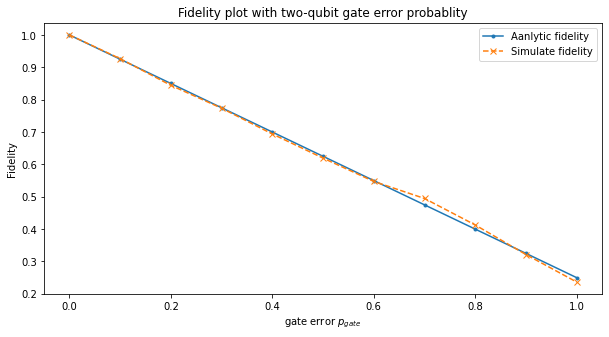

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(gate_error_range, fidelity_TwoGate_error(gate_error_range), '.-', label='Aanlytic fidelity')
plt.plot(gate_error_range, Fidleities, 'x--', label='Simulate fidelity')
plt.legend()
plt.title('Fidelity plot with two-qubit gate error probablity'); plt.xlabel('gate error $p_{gate}$'); plt.ylabel('Fidelity')
# plt.savefig('modelfidelityFigures/CNOTgateFideility.png')

### Depolarizing Channel on single qubit

Initial state is 
$$
\begin{equation}
    \rho = |0\rangle \langle 0| = \frac{1}{2}(I + Z).
\end{equation}
$$

Deporalizing channel is defined by,

$$
\begin{equation}
    \epsilon(\rho) = (1 - p_{\text{dep}}) I \rho I + \frac{p_{\text{dep}}}{3} \sum_{i=X, Y, Z} G \rho G^{\dagger}
\end{equation}
$$

The fidelity is then,
$$
\begin{equation}
    F = \frac{1}{2}(1 + \langle Z \rangle) = 1 - \frac{2p_{\text{dep}}}{3}
\end{equation}
$$


In [13]:
def depolarizing_single_qubit_fidelity(x):
    return 1 - 2*x/3

In [14]:
# Execute experiment as follow

# Define stabilizers set
stabilizers = ['Z']

# Specify number of execution for each gate error
num = 1000

# Define depolarizing error
depolarizing_error_range = np.linspace(0, 1, 11)
depError = [[1 - i, i/3, i/3, i/3] for i in gate_error_range] # Do and Don't

# Result list
Fidleities = []

for d_e in depError:
    
    DEF = DirectFidelityEstimator(stabilizers)
    for index in range(num):
        # Initialize qubit
        test_qubit = GetQubit()

        # Apply custom single qubit error corresponding to depolarizing channel
        test_qubit.applySingleQubitGateError(prob=d_e)

        # Measure for error operator
        DEF.measure(test_qubit)

    Fidleities.append(DEF.estimate_fidelity())

Text(0, 0.5, 'Fidelity')

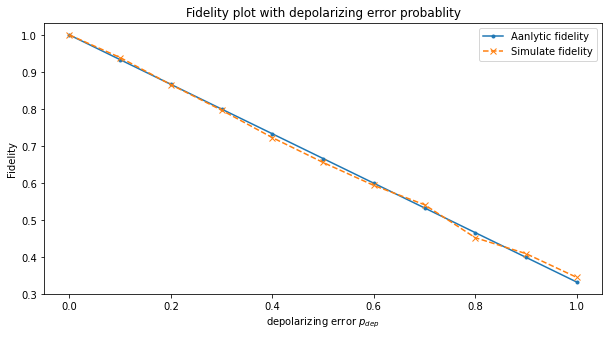

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(depolarizing_error_range, depolarizing_single_qubit_fidelity(depolarizing_error_range), '.-', label='Aanlytic fidelity')
plt.plot(depolarizing_error_range, Fidleities, 'x--', label='Simulate fidelity')
plt.legend()
plt.title('Fidelity plot with depolarizing error probablity'); plt.xlabel('depolarizing error $p_{dep}$'); plt.ylabel('Fidelity')
# plt.savefig('modelfidelityFigures/DepolarizingFideility.png')

### Memory error 

Using the same analysis as in depolarizing channel, the fidelity is therefore,
$$
\begin{equation}
    F = \frac{1}{2}(1 + \langle Z \rangle) = 1 - \frac{2(1 - p_{\text{mem}})}{3}.
\end{equation}
$$
However probability is now depend on time (in second) where,
$$
\begin{equation}
    p_{\text{mem}} = \frac{e^{\frac{-t}{\tau}} + 3}{4}.
\end{equation}
$$

The fidelity become 
$$
\begin{equation}
    F = \frac{1}{6}(5 + e^{\frac{-t}{\tau}})
\end{equation}
$$


In [17]:
def memory_single_qubit_fidelity(x, tau):
    return (5 + np.e**(-x/tau))/6

In [32]:
# Execute experiment as follow

# Define stabilizers set
stabilizers = ['Z']

# Specify number of execution for each gate error
num = 10000

# Define memory error
# np.array([1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001])
memory_error_range = np.linspace(0, 1, 21)
memError = [i for i in memory_error_range] 
tau = 0.1

def memFunc(time, tau=tau):
    p = (np.e**(-1*(time/tau)))/4 + 0.75
    return [p, (1-p)/3, (1-p)/3, (1-p)/3]

# Result list
Fidleities = []

for m_e in memError:
    
    DEF = DirectFidelityEstimator(stabilizers)

    for index in range(num):

        # Initialize qubit
        test_qubit = GetQubit(memoryFunction=memFunc)

        # Set measurement time of test qubit
        test_qubit.env.now = m_e

        # Measure for error operator
        DEF.measure(test_qubit)

    Fidleities.append(DEF.estimate_fidelity())

Text(0, 0.5, 'Fidelity')

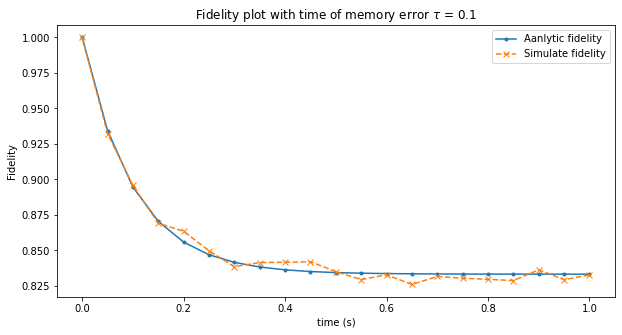

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(memory_error_range, memory_single_qubit_fidelity(memory_error_range, tau), '.-', label='Aanlytic fidelity')
plt.plot(memory_error_range, Fidleities, 'x--', label='Simulate fidelity')
plt.legend()
plt.title(f'Fidelity plot with time of memory error $\\tau$ = {tau}'); plt.xlabel('time (s)'); plt.ylabel('Fidelity')
# plt.savefig('modelfidelityFigures/MemoryFideility.png')

### Measurement error

In [34]:
# Analytic fidelity
def measurement_error(x):
    return 1 - x

In [40]:
# Execute experiment as follow

# Define stabilizers set
stabilizers = ['Z']

# Specify number of execution for each gate error
num = 10000

# Define gate error
measurement_error_range = np.linspace(0, 1, 11)

# Result list
DEF_Fidelities = []

for m_e in measurement_error_range:
    # Initial estimator instance
    DEF = DirectFidelityEstimator(stabilizers)

    for index in range(num):
        # Initialize qubit
        test_qubit = GetQubit(measurementError=m_e)
        # Apply hadamard gate as it does nothing on qubit if there is no piror noise
        test_qubit.I_gate()

        # Measure the qubit
        DEF.measure(test_qubit) 
          
    DEF_Fidelities.append(DEF.estimate_fidelity())

Text(0, 0.5, 'Fidelity')

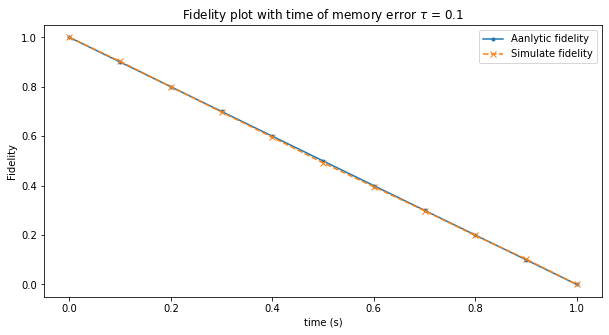

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(measurement_error_range, measurement_error(measurement_error_range), '.-', label='Aanlytic fidelity')
plt.plot(measurement_error_range, DEF_Fidelities, 'x--', label='Simulate fidelity')
plt.legend()
plt.title(f'Fidelity plot with time of memory error $\\tau$ = {tau}'); plt.xlabel('time (s)'); plt.ylabel('Fidelity')
#plt.savefig('modelfidelityFigures/MemoryFideility.png')